In [1]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
import joblib
from datetime import datetime, timedelta
import pymongo
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import json
from pathlib import Path

# Load environment variables
load_dotenv()



True

In [45]:
class PortfolioOptimizer:
    def __init__(self):
        """Initialize the portfolio optimizer."""
        self.model = None
        self.symbols = None
        self.weights = None
        
        # Create directory for outputs
        os.makedirs('outputs', exist_ok=True)
        
        # Load model from MongoDB or local file
        self._load_model()
    
    def _load_model(self):
        """Load the trained model either from MongoDB or local file."""
        try:
            # First try to load from MongoDB
            mongo_uri = os.getenv('MONGO_URI')
            if mongo_uri:
                client = pymongo.MongoClient(mongo_uri)
                db = client.portfolio_optimization
                collection = db.models
                
                # Get the latest model
                latest_model = collection.find_one(sort=[('training_date', pymongo.DESCENDING)])
                
                if latest_model:
                    self.symbols = latest_model['symbols']
                    self.weights = np.array(latest_model['weights'])
                    self.model = {
                        'weights': self.weights,
                        'symbols': self.symbols,
                        'training_date': latest_model['training_date'],
                        'metrics': {
                            'sharpe_ratio': latest_model.get('sharpe_ratio', 0)
                        }
                    }
                    print(f"Model loaded from MongoDB, trained on {latest_model['training_date']}")
                    return
        except Exception as e:
            print(f"Error loading model from MongoDB: {e}")
        
        # Fallback to local file
        try:
            model_path = './Model Backup/portfolio_model.joblib'
            if os.path.exists(model_path):
                self.model = joblib.load(model_path)
                self.symbols = self.model['symbols']
                self.weights = np.array(self.model['weights'])
                print(f"Model loaded from local file, trained on {self.model['training_date']}")
            else:
                raise FileNotFoundError("Model file not found")
        except Exception as e:
            print(f"Error loading model from file: {e}")
            print("Using default equal-weight portfolio as fallback")
            
            # Fallback to default model with equal weights
            self.symbols = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META', 'TSLA', 'NVDA', 'JPM', 'BAC', 'V']
            self.weights = np.ones(len(self.symbols)) / len(self.symbols)
            self.model = {
                'weights': self.weights,
                'symbols': self.symbols,
                'training_date': datetime.now().strftime('%Y-%m-%d'),
                'metrics': {
                    'sharpe_ratio': 0
                }
            }
    
    def fetch_current_data(self, days=30):
        """Fetch recent stock data for the portfolio symbols."""
        end_date = datetime.now()
        start_date = end_date - timedelta(days=days)
        
        # Create a dictionary to hold DataFrames for each symbol
        data_dict = {}
        
        for symbol in self.symbols:
            try:
                data = yf.download(symbol, start=start_date, end=end_date)
                if not data.empty:
                    # Calculate daily returns
                    data['Returns'] = data['Close'].pct_change()
                    # Store in dictionary with symbol as key
                    data_dict[symbol] = data
                else:
                    print(f"No data found for {symbol}")
            except Exception as e:
                print(f"Error fetching data for {symbol}: {e}")
        
        return data_dict
    
    def get_portfolio_allocation(self):
        """Return the current portfolio allocation."""
        return {symbol: weight for symbol, weight in zip(self.symbols, self.weights)}
    
    def calculate_portfolio_performance(self, days=30):
        """Calculate performance metrics for the portfolio."""
        # Fetch recent data
        data_dict = self.fetch_current_data(days)
        
        # Extract returns and close prices into separate DataFrames
        returns_data = pd.DataFrame()
        price_data = pd.DataFrame()
        
        for symbol in self.symbols:
            if symbol in data_dict:
                # Add returns to returns_data DataFrame
                returns_data[symbol] = data_dict[symbol]['Returns']
                # Add close prices to price_data DataFrame
                price_data[symbol] = data_dict[symbol]['Close']
        
        # Drop NaN values
        returns_data = returns_data.dropna()
        price_data = price_data.dropna()
        
        # Calculate daily portfolio returns
        portfolio_returns = returns_data.dot(self.weights)
        
        # Calculate metrics
        cumulative_return = (1 + portfolio_returns).prod() - 1
        annualized_return = (1 + cumulative_return) ** (252 / len(portfolio_returns)) - 1
        volatility = portfolio_returns.std() * np.sqrt(252)
        sharpe_ratio = annualized_return / volatility if volatility > 0 else 0
        
        # Print some debug information
        print('Checker 1')
        print(price_data.head(5))
        
        # Normalize prices
        normalized_prices = price_data / price_data.iloc[0]
        
        # Calculate portfolio value over time
        portfolio_value = normalized_prices.dot(self.weights)
        
        # Create performance chart
        import matplotlib.colors as mcolors
        import os # To ensure the output directory exists

        # --- Assume these are your data variables ---
        # portfolio_value = pd.Series(...) # Your portfolio value Series (index=datetime, values=float)
        # normalized_prices = pd.DataFrame(...) # DataFrame of normalized stock prices (index=datetime, columns=symbols)
        # self.symbols = [...] # List of stock symbols
        # ------------------------------------------

        # Ensure the output directory exists
        output_dir = 'outputs'
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        output_path = os.path.join(output_dir, 'portfolio_performance.png')

        # --- Plotting Enhancements ---

        plt.style.use('default') # Start with a default style

        fig, ax = plt.subplots(figsize=(14, 8)) # Use fig, ax for better control

        # Define a color cycle for stocks (using a perceptually uniform colormap)
        # Using 'tab10' or 'tab20' is also a good choice for distinct colors
        stock_colors = plt.cm.viridis(np.linspace(0, 1, len(self.symbols)))

        # 1. Plot Portfolio Line (Make it prominent)
        portfolio_color = '#003366' # Or a strong distinct color like '#003366' (dark blue)
        ax.plot(portfolio_value.index, portfolio_value.values,
                label='Portfolio',
                color=portfolio_color,
                linewidth=3, # Thicker line
                zorder=10) # Ensure it's on top

        # 2. Plot Individual Stocks (Make them less prominent)
        for i, symbol in enumerate(self.symbols):
            if symbol in normalized_prices.columns:
                ax.plot(normalized_prices.index, normalized_prices[symbol],
                        label=symbol,
                        color=stock_colors[i],
                        linewidth=1.5, # Thinner than portfolio
                        alpha=0.6) # More transparent

        # 3. Customize Labels and Title
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('Normalized Value', fontsize=12)
        ax.set_title('Portfolio Performance Over Time', fontsize=16, fontweight='bold', pad=20)

        # 4. Enhance Legend
        # Place legend outside or let matplotlib find the best spot, reduce clutter
        legend = ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0.,
                        fontsize=10, title='Assets', title_fontsize=11,
                        frameon=False) # No frame for cleaner look
        # Optional: Make legend text slightly gray
        # for text in legend.get_texts():
        #     text.set_color('dimgray')

        # 5. Refine Grid
        ax.grid(True, which='major', linestyle='--', linewidth=0.5, color='grey', alpha=0.5)

        # 6. Customize Spines (Axis borders) for a cleaner look
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('grey')
        ax.spines['bottom'].set_color('grey')

        # 7. Customize Ticks
        ax.tick_params(axis='x', rotation=45, colors='dimgray', labelsize=10) # Rotate date labels
        ax.tick_params(axis='y', colors='dimgray', labelsize=10)
        ax.tick_params(axis='both', direction='in', length=4) # Ticks pointing inwards

        # 8. Adjust Layout
        plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust rect to make space for legend outside

        # 9. Save the chart with TRANSPARENT background
        # Use facecolor='none' for the figure. Also save with transparent=True.
        fig.patch.set_facecolor('none') # Set figure background transparent
        ax.patch.set_facecolor('none')  # Set axes background transparent

        plt.savefig(output_path,
                    dpi=300, # Higher resolution
                    bbox_inches='tight', # Fit plot tightly
                    transparent=True) # Explicitly save with transparency

        print(f"Plot saved to {output_path}")
        plt.show()
        
        # Save metrics
        metrics = {
            'cumulative_return': float(cumulative_return),
            'annualized_return': float(annualized_return),
            'volatility': float(volatility),
            'sharpe_ratio': float(sharpe_ratio),
            'evaluation_date': datetime.now().strftime('%Y-%m-%d'),
            'evaluation_period_days': days
        }
        
        with open('outputs/performance_metrics.json', 'w') as f:
            json.dump(metrics, f, indent=4)
        
        return metrics, portfolio_value
    
    def generate_recommendation(self):
        """Generate investment recommendations based on the optimal portfolio."""
        allocation = self.get_portfolio_allocation()
        metrics, _ = self.calculate_portfolio_performance()
        
        # Sort stocks by weight
        sorted_allocation = {k: v for k, v in sorted(allocation.items(), key=lambda item: item[1], reverse=True)}
        
        # Generate recommendation
        recommendation = {
            'optimal_allocation': sorted_allocation,
            'performance_metrics': metrics,
            'recommendation_date': datetime.now().strftime('%Y-%m-%d'),
            'model_training_date': str(self.model['training_date']),
        }
        
        # Save recommendation
        with open('outputs/recommendation.json', 'w') as f:
            json.dump(recommendation, f, indent=4)
        
        return recommendation

In [46]:
optimizer = PortfolioOptimizer()

# Generate recommendation


Model loaded from MongoDB, trained on 2025-04-29 15:31:11.770000


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Checker 1
                  AAPL        MSFT        GOOG        AMZN        META  \
Date                                                                     
2025-03-31  222.130005  375.390015  156.229996  190.259995  576.359985   
2025-04-01  223.190002  382.190002  158.880005  192.169998  586.000000   
2025-04-02  223.889999  382.140015  158.860001  196.009995  583.929993   
2025-04-03  203.190002  373.109985  152.630005  178.410004  531.619995   
2025-04-04  188.380005  359.839996  147.740005  171.000000  504.730011   

                  TSLA        NVDA         JPM        BAC           V  
Date                                                                   
2025-03-31  259.160004  108.379997  243.798325  41.730000  350.459991  
2025-04-01  268.459991  110.150002  242.168365  41.490002  346.350006  
2025-04-02  282.760010  110.419998  244.315140  41.849998  346.329987  
2025-04-03  267.279999  101.800003  227.290009  37.220001  339.390015  
2025-04-04  239.429993   94.309998  210

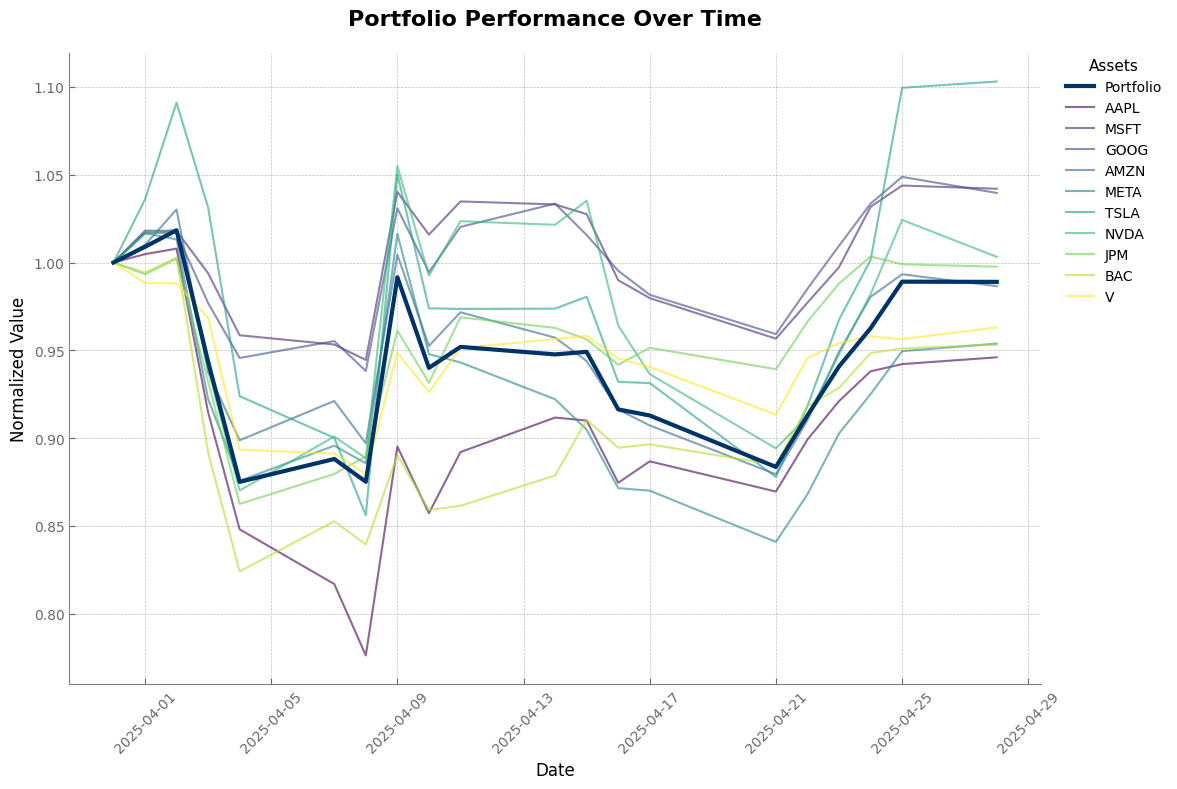

In [47]:
recommendation = optimizer.generate_recommendation()

In [ ]:


# Print summary
print("\nOptimal Portfolio Allocation:")
for symbol, weight in recommendation['optimal_allocation'].items():
    print(f"  {symbol}: {weight:.2%}")

print("\nPortfolio Performance Metrics:")
metrics = recommendation['performance_metrics']
print(f"  Cumulative Return: {metrics['cumulative_return']:.2%}")
print(f"  Annualized Return: {metrics['annualized_return']:.2%}")
print(f"  Volatility: {metrics['volatility']:.2%}")
print(f"  Sharpe Ratio: {metrics['sharpe_ratio']:.2f}")

print("\nRecommendation saved to outputs/recommendation.json")
print("Performance chart saved to outputs/portfolio_performance.png") 